In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import count
from __future__ import division

In [2]:
df_train = pd.read_csv('train.tsv',sep='\t')

print 'Train shape: {}'.format(df_train.shape)
print 'Number of unique sentences: {}'.format(len(df_train.loc[:, 'SentenceId'].unique()))

Train shape: (156060, 4)
Number of unique sentences: 8529


In [3]:
df_train.head(2)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2


# 1. 句子的长度分布情况

In [4]:
sentence_lens = df_train.Phrase.str.split().apply(lambda x:len(x)).values

bins = []
for num in np.unique(sentence_lens):
    bins.append(num-0.4)
    bins.append(num+0.4)

bin_count = np.bincount(sentence_lens)
bin_count_cumsum = np.cumsum(bin_count)

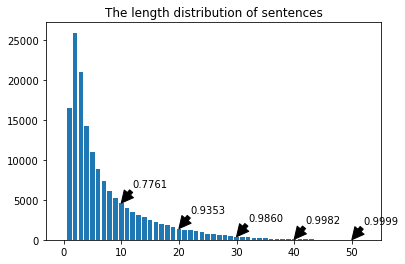

In [5]:
_ = plt.hist(sentence_lens, bins=bins)
plt.title('The length distribution of sentences')
for i in count(1):
    if i*10>len(bins)/2:
        break
    y = bin_count[i*10]
    x = i*10
    s = '{:.4f}'.format(bin_count_cumsum[10*i]/sum(bin_count))
    plt.annotate(s, xy=(x, y), xytext=(x+2, y+2000),
            arrowprops=dict(facecolor='black', shrink=0.0001),
            )

arrow指示的是小于该长度的句子占总的句子的比例。这里使用30作为trim size。即长度小于30的句子被padding到30；长于30的句子，随机选取连续的30个词作为特征。

# 2.1 LogisticRegression

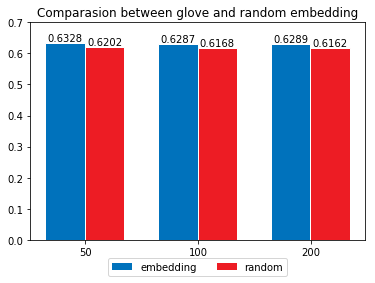

In [195]:
scores = (list(i for i in val_acc[::2]),list(i for i in val_acc[1::2]))

plot_bars(scores)

(1)从上图可以看出，效果最好的是embedding size为50，推测原因是由于，大部分句子的长度都比较短，使用更长的embedding导致了训练难度增加，但并不能直接给这个比较简单的任务带来准确率的增益。  
(2)不论从那个embed size来看，使用glove的准确率都是要略高于random embedding的。

# 2.2 CBOW

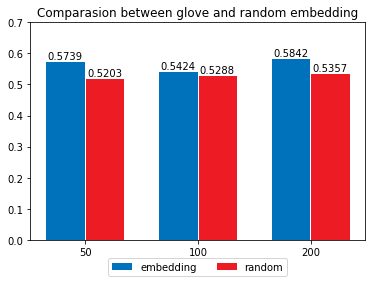

In [19]:
scores = (list(i for i in val_acc[::2]),list(i for i in val_acc[1::2]))

plot_bars(scores)

（1）从上图可以看出，random方式的embedding，随着dimension的上升，正确率也在上升。  
（2)GLove初始化在任何dimension下都比对应的random要好
（3）LogisticRegression取得了更高的准确率。

In [6]:
import random

class WordDictionary:
    def __init__(self):
        self.word2index = {'<unknown>':1, '<pad>':0}
        self.n_words = len(self.word2index)
    def addSentence(self, sen):
        words = sen.split()
        for idx in xrange(len(words)):
            word = words[idx]
            if not self.word2index.has_key(word):
                self.word2index[word] = self.n_words
                self.n_words += 1
    def vecterize(self, sentence, pad_len=30):
        """
        pad_len: serves both as pad_len adn trim_len
        """
        words = sentence.split()
        vector = np.zeros(pad_len) * self.word2index['<pad>']
        if len(words)>pad_len:
            start = np.random.randint(len(words)-pad_len+1)
            words = words[start:start+pad_len]
            assert len(words)==pad_len
        for i in xrange(len(words)):
            vector[i] = self.word2index[words[i]]
        return vector

In [7]:
import random
import scipy
from scipy.sparse import vstack

def val_split(df, val_size=0.2):
    """
    This method considers Stratified sampling.
    """
    y = df.iloc[:, -1]
    classes = y.unique()
    train_idx = []
    val_idx = []
    for class_ in classes:
        bool_indexes = (y==class_)
        indexes = y[bool_indexes].index.tolist()
        length = len(indexes)
        random.shuffle(indexes)
        train_idx.extend(indexes[:-int(length*val_size)])
        val_idx.extend(indexes[-int(length*val_size):])
    random.shuffle(train_idx)
    random.shuffle(val_idx)
        
    return train_idx, val_idx

def word2index(df_data, words):
    Xs = []
    ys = []
    for data in df_data.itertuples():
        Xs.append(words.vecterize(data[1],))
        ys.append(data[2])
    if isinstance(Xs[0], scipy.sparse.csc.csc_matrix):
        Xs = vstack(Xs,format='csc')
    else:
        Xs = np.array(Xs,dtype=int)
    return Xs, np.asarray(ys, dtype=int)

In [8]:
train_idx, val_idx = val_split(df_train.iloc[:, -2:], val_size=0.2)

In [9]:
wordDictionary = WordDictionary()

for data in df_train['Phrase']:
    wordDictionary.addSentence(data)

print "Train vocabulary size: {}".format(wordDictionary.n_words)

#向量化
train_Xs,train_ys = word2index(df_train.iloc[train_idx, -2:], wordDictionary)
val_Xs, val_ys = word2index(df_train.iloc[val_idx, -2:], wordDictionary)
print 'trainX shape:{}'.format(train_Xs.shape)

Train vocabulary size: 18228
trainX shape:(124850, 30)


In [10]:
#如何读取glove中的数据
DEFAULT_FILE_PATH = 'glove/glove.6B.50d.txt'
def loadWordVectors(word2index, filepath=DEFAULT_FILE_PATH, dimensions=50):
    """Read pretrained GloVe vectors"""
    wordVectors = np.zeros((len(word2index), dimensions),dtype=float)
    with open(filepath) as ifs:
        for line in ifs:
            line = line.strip()
            if not line:
                continue
            row = line.split()
            token = row[0]
            if token not in word2index:
                continue
            data = [float(x) for x in row[1:]]
            if len(data) != dimensions:
                raise RuntimeError("wrong number of dimensions")
            wordVectors[word2index[token]] = np.asarray(data)
    return wordVectors

In [11]:
from torch import nn
import torch as T
import torch.nn.functional as F

In [12]:
class LogisticRegression(nn.Module):
    def __init__(self, vocab_size, embed_size, n_features, n_classes):
        super(LogisticRegression, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        
        self.embed_size = embed_size
        self.n_features = n_features
        
        self.fc1 = nn.Linear(n_features*embed_size, n_classes)
        self.softmax = nn.Softmax()
    def initEmbedding(self, embed,requires_grad=True):
        self.embedding.weight = nn.Parameter(T.from_numpy(embed).type(FloatTensor), requires_grad=requires_grad)
    
    def forward(self, x):
        x = self.embedding(x).view(-1, self.n_features*self.embed_size)
        x = self.fc1(x)
        x = self.softmax(x)
        return x
    
class LogisticRegressionCBOW(nn.Module):
    def __init__(self, vocab_size, embed_size, n_features, n_classes):
        super(LogisticRegressionCBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        
        self.embed_size = embed_size
        self.n_features = n_features
        
        self.fc1 = nn.Linear(embed_size, n_classes)
        self.softmax = nn.Softmax()
        
    def initEmbedding(self, embed,requires_grad=True):
        self.embedding.weight = nn.Parameter(T.from_numpy(embed).type(FloatTensor),requires_grad=requires_grad)
    
    def forward(self, x):
        #lens = T.sum(x!=0, dim=1, keepdim=True).type(FloatTensor)+1
        x = self.embedding(x)
        #x = T.sum(x, dim=1)/lens
        x = T.mean(x, dim=1)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [13]:
（1）从上图可以看出，random方式的embedding，随着dimension的上升，正确率也在上升。  
（2)GLove初始化在任何dimension下都比对应的random要好import random
from torch.autograd import Variable

USE_CUDA = T.cuda.is_available()
LongTensor = T.cuda.LongTensor if USE_CUDA else T.LongTensor
FloatTensor = T.cuda.FloatTensor if USE_CUDA else T.FloatTensor

def get_batch(X, y, batch_size):
    """
    X,y: numpy array. cannot be list
    """
    indexes = list(range(len(y)))
    random.shuffle(indexes)
    sindex = 0
    eindex = batch_size
    while eindex<len(y):
        index = indexes[sindex:eindex]
        yield X[index], y[index]
        sindex= eindex
        eindex += batch_size
    if sindex<len(y):
        index = indexes[sindex:]
        yield X[index], y[index]

def trainIter(model, Xs, ys, optimizer, criterion, iterations=20, batch_size=32, print_every=100,
              scheduler=None):
    for iter in xrange(iterations):
        print '-'*10
        print_loss = 0.0
        idx = 0
        if scheduler!=None:
            scheduler.step()
        for X, y in get_batch(Xs, ys, batch_size):
            X = Variable(LongTensor(X))
            y = Variable(LongTensor(y))
            output = model(X)
            optimizer.zero_grad()
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            print_loss += loss.data[0]
            if (idx+1)%print_every==0:
                print "[{}/{}] loss:{:.4f}".format(iter+1, iterations, print_loss/(idx+1))
                print_loss = 0.0
                idx = 0
            idx += 1
            
def evaluate(model, Xs, ys, batch_size):
    corrects = 0.0
    for X, y in get_batch(Xs, ys, batch_size):
        X = Variable(LongTensor(X))
        y = LongTensor(y)
        output = model(X)
        predicts = output.data.max(1)[1]
        corrects += (predicts==y).sum()
    return corrects/len(Xs)

In [14]:
from torch import optim
from torch.optim.lr_scheduler import StepLR
from itertools import product

# 2.1 LogisticRegression

In [172]:
val_acc = [] 

for embed_size, init_flag in product([50, 100, 200], [True, False]):
    model = LogisticRegression(len(wordDictionary.word2index), embed_size, 30, 5)
    if init_flag:
        file_path = 'glove/glove.6B.%dd.txt'%(embed_size)
        wordVectors = loadWordVectors(wordDictionary.word2index, file_path, embed_size)
        model.initEmbedding(wordVectors, requires_grad=True)

    if USE_CUDA:
        model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=1.1, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    criterion = nn.CrossEntropyLoss()
    trainIter(model, train_Xs, train_ys, optimizer,criterion, iterations=30, batch_size=64, print_every=1000,
              scheduler=scheduler)
    val_acc.append(evaluate(model, val_Xs, val_ys, 128))
    print embed_size, init_flag, val_acc[-1]
    

----------
[1/30] loss:1.3660
----------
[2/30] loss:1.3182
----------
[3/30] loss:1.2975
----------
[4/30] loss:1.2846
----------
[5/30] loss:1.2755
----------
[6/30] loss:1.2690
----------
[7/30] loss:1.2607
----------
[8/30] loss:1.2552
----------
[9/30] loss:1.2538
----------
[10/30] loss:1.2507
----------
[11/30] loss:1.2421
----------
[12/30] loss:1.2389
----------
[13/30] loss:1.2380
----------
[14/30] loss:1.2367
----------
[15/30] loss:1.2345
----------
[16/30] loss:1.2315
----------
[17/30] loss:1.2302
----------
[18/30] loss:1.2307
----------
[19/30] loss:1.2275
----------
[20/30] loss:1.2275
----------
[21/30] loss:1.2217
----------
[22/30] loss:1.2192
----------
[23/30] loss:1.2188
----------
[24/30] loss:1.2190
----------
[25/30] loss:1.2173
----------
[26/30] loss:1.2190
----------
[27/30] loss:1.2170
----------
[28/30] loss:1.2155
----------
[29/30] loss:1.2144
----------
[30/30] loss:1.2143
50 True 0.632809996796
----------
[1/30] loss:1.3938
----------
[2/30] loss:1.3

In [18]:
def plot_bars(scores):
    names = ['embedding', 'random']
    dims = [50, 100, 200]
    bar_width = 0.35
    index = np.arange(len(scores[0]))
    rects1 = plt.bar(index, scores[0], bar_width, color='#0072BC', label=names[0])
    rects2 = plt.bar(index + bar_width, scores[1], bar_width, color='#ED1C24', label=names[1])
    plt.xticks(index + 0.18, dims)
    plt.ylim(ymax=0.7, ymin=0)
    plt.title(u'Comparasion between glove and random embedding')
    # 图例显示在图表下方
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, ncol=5)

    # 添加数据标签
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            s = '%.4f'%(height)
            plt.text(rect.get_x() + rect.get_width() / 2, height, s, ha='center', va='bottom')
            # 柱形图边缘用白色填充，纯粹为了美观
            rect.set_edgecolor('white')

    add_labels(rects1)
    add_labels(rects2)
    

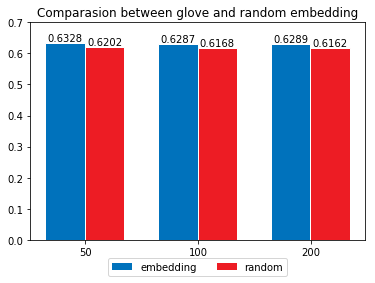

In [195]:
scores = (list(i for i in val_acc[::2]),list(i for i in val_acc[1::2]))

plot_bars(scores)

(1)从上图可以看出，效果最好的是embedding size为50，推测原因是由于，大部分句子的长度都比较短，使用更长的embedding导致了训练难度增加，但并不能直接给这个比较简单的任务带来准确率的增益。  
(2)不论从那个embed size来看，使用glove的准确率都是要略高于random embedding的。

# 2.2 CBOW LogisticRegression

In [16]:
val_acc = [] 

for embed_size, init_flag in product([50, 100, 200], [True, False]):
    model = LogisticRegressionCBOW(len(wordDictionary.word2index), embed_size, 30, 5)
    if init_flag:
        DEFAULT_FILE_PATH = 'glove/glove.6B.%dd.txt'%(embed_size)
        wordVectors = loadWordVectors(wordDictionary.word2index, DEFAULT_FILE_PATH, embed_size)
        model.initEmbedding(wordVectors, requires_grad=True)

    if USE_CUDA:
        model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=0.6)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    criterion = nn.CrossEntropyLoss()
    trainIter(model, train_Xs, train_ys, optimizer,criterion, iterations=20, batch_size=64, print_every=1000,
              scheduler=scheduler)
    val_acc.append(evaluate(model, val_Xs, val_ys, 128))
    print embed_size, init_flag, val_acc[-1]
    

----------
[1/20] loss:1.4021
----------
[2/20] loss:1.3784
----------
[3/20] loss:1.3713
----------
[4/20] loss:1.3690
----------
[5/20] loss:1.3632
----------
[6/20] loss:1.3604
----------
[7/20] loss:1.3549
----------
[8/20] loss:1.3516
----------
[9/20] loss:1.3461
----------
[10/20] loss:1.3426
----------
[11/20] loss:1.3408
----------
[12/20] loss:1.3376
----------
[13/20] loss:1.3364
----------
[14/20] loss:1.3368
----------
[15/20] loss:1.3333
----------
[16/20] loss:1.3298
----------
[17/20] loss:1.3310
----------
[18/20] loss:1.3264
----------
[19/20] loss:1.3275
----------
[20/20] loss:1.3254
50 True 0.573886574816
----------
[1/20] loss:1.4064
----------
[2/20] loss:1.3984
----------
[3/20] loss:1.3932
----------
[4/20] loss:1.3959
----------
[5/20] loss:1.3968
----------
[6/20] loss:1.3919
----------
[7/20] loss:1.3958
----------
[8/20] loss:1.3939
----------
[9/20] loss:1.3867
----------
[10/20] loss:1.3822
----------
[11/20] loss:1.3847
----------
[12/20] loss:1.3794
---

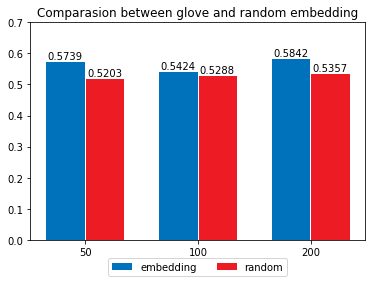

In [19]:
scores = (list(i for i in val_acc[::2]),list(i for i in val_acc[1::2]))

plot_bars(scores)

（1）从上图可以看出，random方式的embedding，随着dimension的上升，正确率也在上升。  
（2)GLove初始化在任何dimension下都比对应的random要好